<a href="https://colab.research.google.com/github/maengg/ML_Project/blob/main/Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***라이브러리 설치***

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install xgboost
    !pip install imbalanced-learn

In [1]:
from google.colab import files
upload = files.upload()

Saving bank-direct-marketing-campaigns.csv to bank-direct-marketing-campaigns.csv


## 데이터 설명
- 포르투갈 은행 기관의 직접 마케팅 캠페인과 관련된 기록
- 2008년 5월~2010년 11월까지의 데이터.

In [2]:
import pandas as pd

df = pd.read_csv('bank-direct-marketing-campaigns.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 20)

## 가설
- 경기지표가 정기예금 가입하는 결과에 큰 영향을 끼칠 것이다. 
- 너무 자주 고객에게 접촉한다면 반감이 생겨 마케팅 결과에 안좋은 영향을 끼칠 것이다.

## 전처리 및 EDA

In [4]:
# 마케팅의 결과가 성공인지 아닌지를 나타내는 특성인 y를 타겟으로 설정.
target = 'y'

# 타겟 불균형 확인 (8:1)
df[target].value_counts(normalize=True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

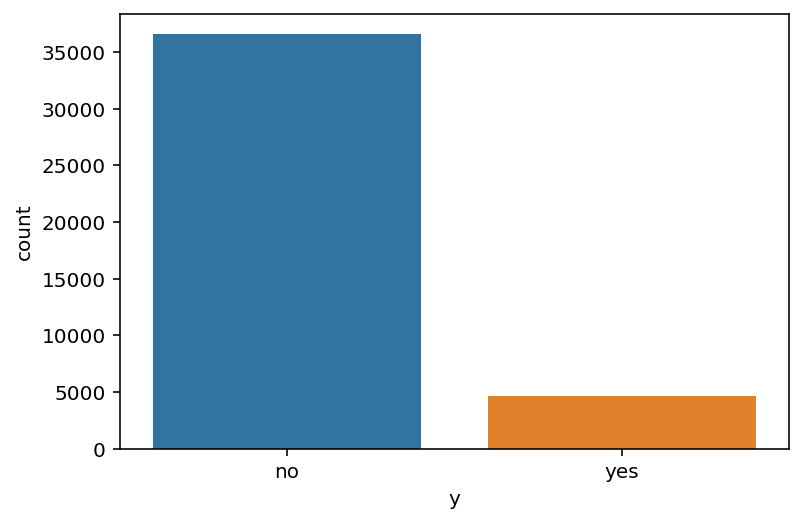

In [ ]:
# 타겟 불균형 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

sns.countplot(x = df[target]);

In [5]:
# 결측치 없음
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [ ]:
import pandas_profiling
df.profile_report()
# 특성들간 상관관계가 있기에 트리모델 적절할 것으로 예상.

In [6]:
# 중복 데이터 확인
df.duplicated().sum()

1784

In [ ]:
# 중복 데이터 제거 및 확인.
df.drop_duplicates(inplace = True)
print(df.duplicated().sum())

0


In [ ]:
df.shape

(39404, 20)

In [ ]:
df['pdays'] = pd.cut(x = df['pdays'], bins = [-1,10,20,30,999], 
                     labels = ['within_10', 'within_20', 'within_30','not_contacted'])

In [ ]:
# 원칙적으로 소비자 물가지수와 소비자 신뢰지수가 높을 수록 소비가 많아지고 저축이 줄어든다는 예상으로 두 특성을 합친 특성을 만든다.
df['cons'] = df['cons.conf.idx'] + df['cons.price.idx']

In [ ]:
df['y'].replace({'no' : 0, 'yes' : 1}, inplace=True)

In [ ]:
# 신용과 관련있는 특성 추가.
df['credit'] = df['default'].replace({'no' : 0, 'unknown' : 0, 'yes' :1}) + df['housing'].replace({'no' : 0, 'unknown' : 0, 'yes' :1}) + df['loan'].replace({'no' : 0, 'unknown' : 0, 'yes' :1})

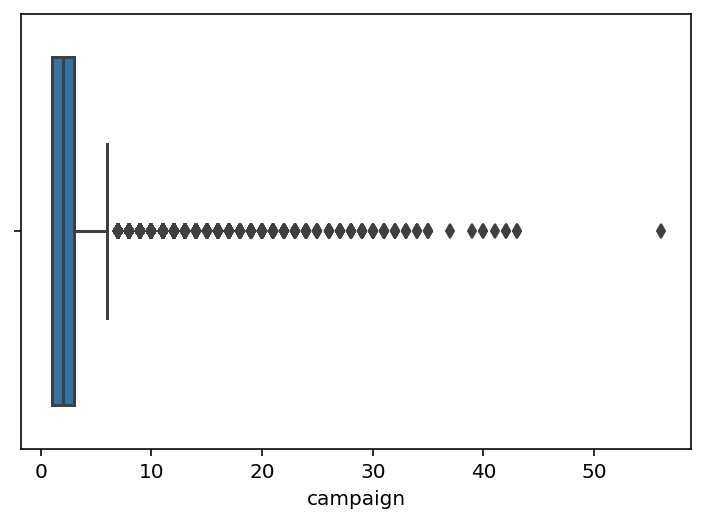

In [ ]:
sns.boxplot(x = df['campaign']);

In [ ]:
# 이상치 제거
from scipy import stats
import numpy as np

df_cleaned = df[np.abs(stats.zscore(df['campaign']))<3]

In [ ]:
df_cleaned['campaign'].max()

11

In [ ]:
df_cleaned.drop(columns = 'previous', inplace =True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_cleaned.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cons,credit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,57.594,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,57.594,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,57.594,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,57.594,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,57.594,1


In [ ]:
# EDA 진행 후 프로파일링
import pandas_profiling
df_cleaned.profile_report()

## 모델링

In [ ]:
# train, val, test 구분
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_cleaned, test_size = 0.2, random_state=2)
train, val = train_test_split(train, test_size = 0.2, stratify = train[target], random_state=2)

train.shape, val.shape, test.shape

((24776, 21), (6194, 21), (7743, 21))

In [ ]:
feature = train.drop(columns= target).columns

In [ ]:
X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

## 평가지표 선정 및 베이스라인 모델 구축

In [ ]:
# 타겟 불균형이 심하기 때문에 f1_score를 검증스코어로 사용.
# 다수 클래스를 베이스라인으로 사용했을 때 f1_score의 경우 0 이 나오기에 이를 베이스라인으로 선택하는 건 적절하지 않다.

from sklearn.metrics import f1_score
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

baseline = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(solver = 'liblinear')
)

baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_val)
f1_score(y_val, baseline_pred)

0.3127035830618893

베이스라인 모델의 경우 성능 **0.31**

## 모델 선택 (RandomForestClassifier & XGBClassifier)

### RF

In [ ]:
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint

pipe = make_pipeline(
    TargetEncoder(),
    RandomForestClassifier(class_weight= 'balanced', random_state=2)
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.],
    'targetencoder__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__n_estimators' : randint(50,300),
    'randomforestclassifier__max_depth' : randint(5,20),
    'randomforestclassifier__max_features' : uniform(0,1),
    'randomforestclassifier__min_samples_leaf': randint(1,10)
}

clf = RandomizedSearchCV(
    pipe,
    param_distributions = dists,
    n_iter = 50,
    cv=4,
    scoring = 'f1',
    verbose = 1,
    n_jobs= -1,
    random_state = 2
)

clf.fit(X_train, y_train);

Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [ ]:
print(clf.best_params_)
print('f1_scroe : ', clf.best_score_)

{'randomforestclassifier__max_depth': 13, 'randomforestclassifier__max_features': 0.29517230521974247, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 99, 'targetencoder__min_samples_leaf': 4, 'targetencoder__smoothing': 60.0}
f1_scroe :  0.5014737268687948


In [ ]:
pipe = clf.best_estimator_

RF 검증 데이터 결과 : 0.4939130434782608

In [ ]:
y_pred = pipe.predict(X_val)
f1_score(y_val, y_pred)

0.4939130434782608

### XGB

In [ ]:
ratio = train[target].value_counts().tolist()[0]/train[target].value_counts().tolist()[1]
ratio

7.540503274732851

In [ ]:
from xgboost import XGBClassifier
encoder = TargetEncoder(smoothing = 100, min_samples_leaf= 2)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

model_xgb = XGBClassifier(max_depth = 7, learning_rate = 0.2, min_child_weight = 4, gamma = 0.55,
                          subsample = 0.5, n_estimators = 1000, scale_pos_weights = ratio, random_state=2)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

model_xgb.fit(X_train_encoded, y_train,
              eval_set = eval_set,
              eval_metric = 'logloss',
              early_stopping_rounds=100);

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_val,model_xgb.predict(X_val_encoded))

0.39138943248532293

RF(0.49)  >  XGB(0.39)

**RF** 모델 선택

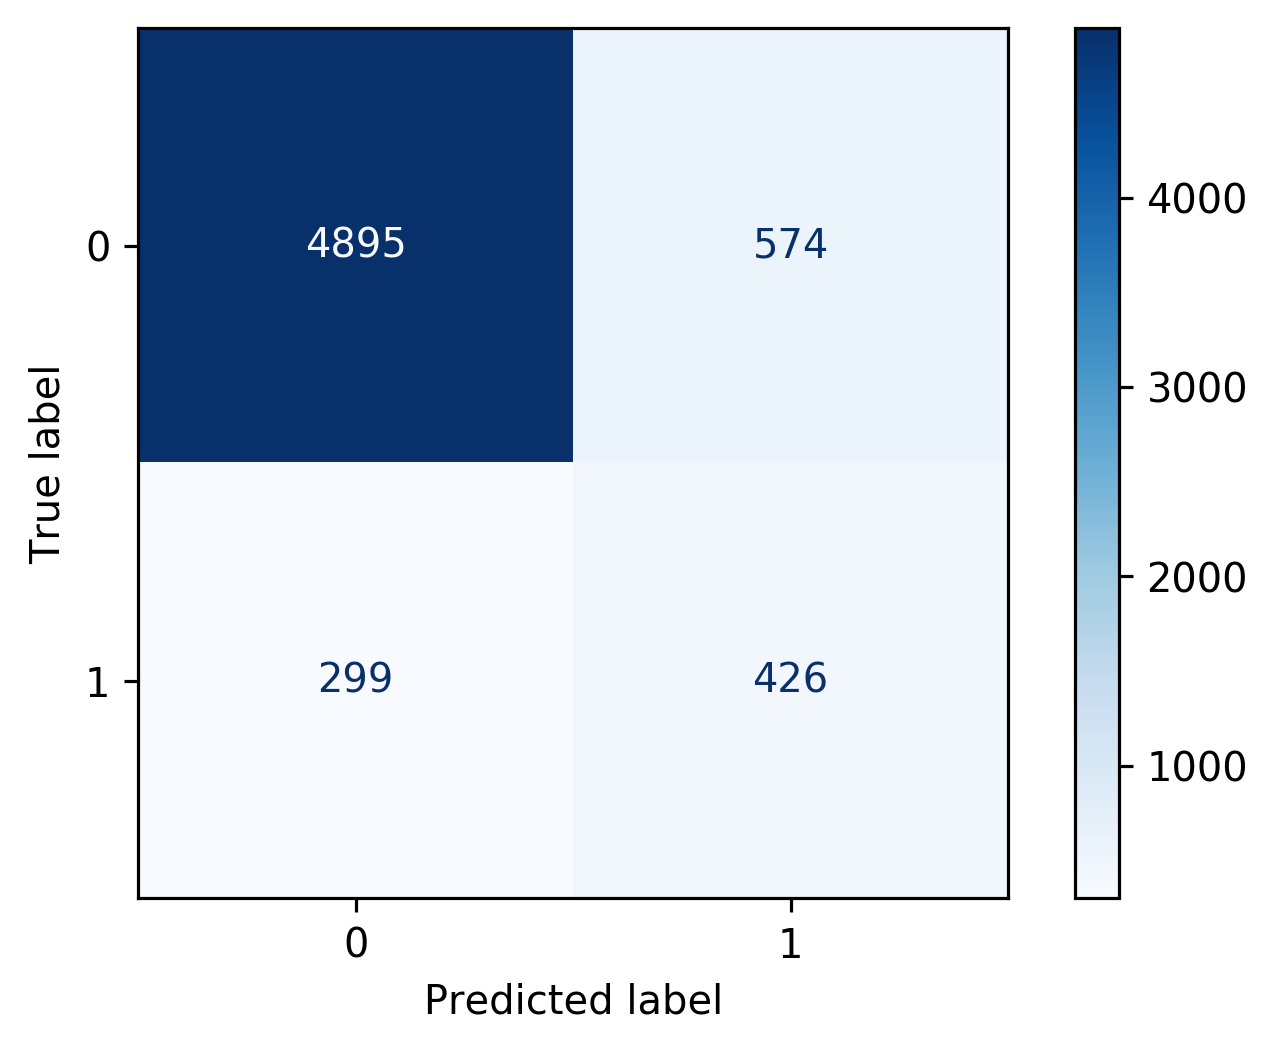

In [ ]:
# confusion_matrix 확인.
from sklearn.metrics import plot_confusion_matrix

pcm = plot_confusion_matrix(
    pipe, X_val, y_val,
    cmap = plt.cm.Blues
)

1이라고 예측했지만 0인 경우가 많음. 따라서 **임계값을 올리는 게 좋을 것**이라고 생각.

In [ ]:
# 임계값 수정.
y_pred_proba = pipe.predict_proba(X_val)[:,1]
y_pred_optimal = y_pred_proba >= 0.56
f1_score(y_val, y_pred_optimal)

0.5064695009242144

In [ ]:
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5469
           1       0.46      0.57      0.51       725

    accuracy                           0.87      6194
   macro avg       0.70      0.74      0.72      6194
weighted avg       0.88      0.87      0.88      6194



In [ ]:
y_pred_proba_test = pipe.predict_proba(X_test)[:,1]
y_pred_optimal_test = y_pred_proba_test >= 0.56
print('test 검증 결과 : ',f1_score(y_test, y_pred_optimal_test))

test 검증 결과 :  0.5272641062114747


RF 테스트 검증 결과 : 0.5272641062114747

## 모델 해석

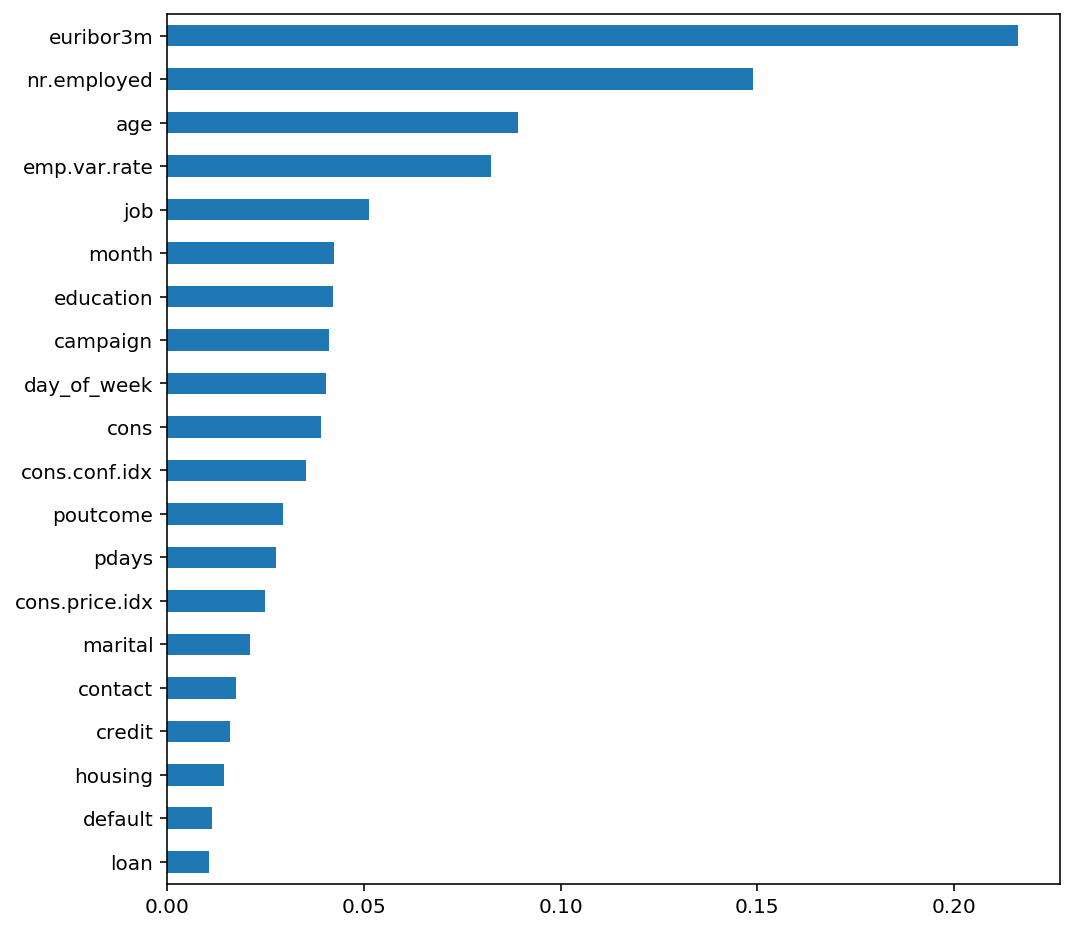

In [ ]:
# 특성 중요도 확인.
plt.figure(figsize=(8,8))
pd.Series(pipe.named_steps['randomforestclassifier'].feature_importances_,X_train.columns).sort_values().plot.barh();

In [ ]:
# 순열 중요도 확인
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['randomforestclassifier'],
    scoring = 'f1',
    n_iter = 5,
    random_state =2 
)

X_val_transformed = pipe.named_steps['targetencoder'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [ ]:
eli5.show_weights(
    permuter,
    top = None,
    feature_names = X_val_transformed.columns.tolist()
)

Weight,Feature
0.0281 ± 0.0114,euribor3m
0.0269 ± 0.0042,month
0.0237 ± 0.0099,nr.employed
0.0108 ± 0.0026,day_of_week
0.0099 ± 0.0091,emp.var.rate
0.0052 ± 0.0054,contact
0.0037 ± 0.0024,pdays
0.0025 ± 0.0014,cons.price.idx
0.0008 ± 0.0021,cons
0.0007 ± 0.0046,housing


## 모델 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

### 직원수와 마케팅 결과

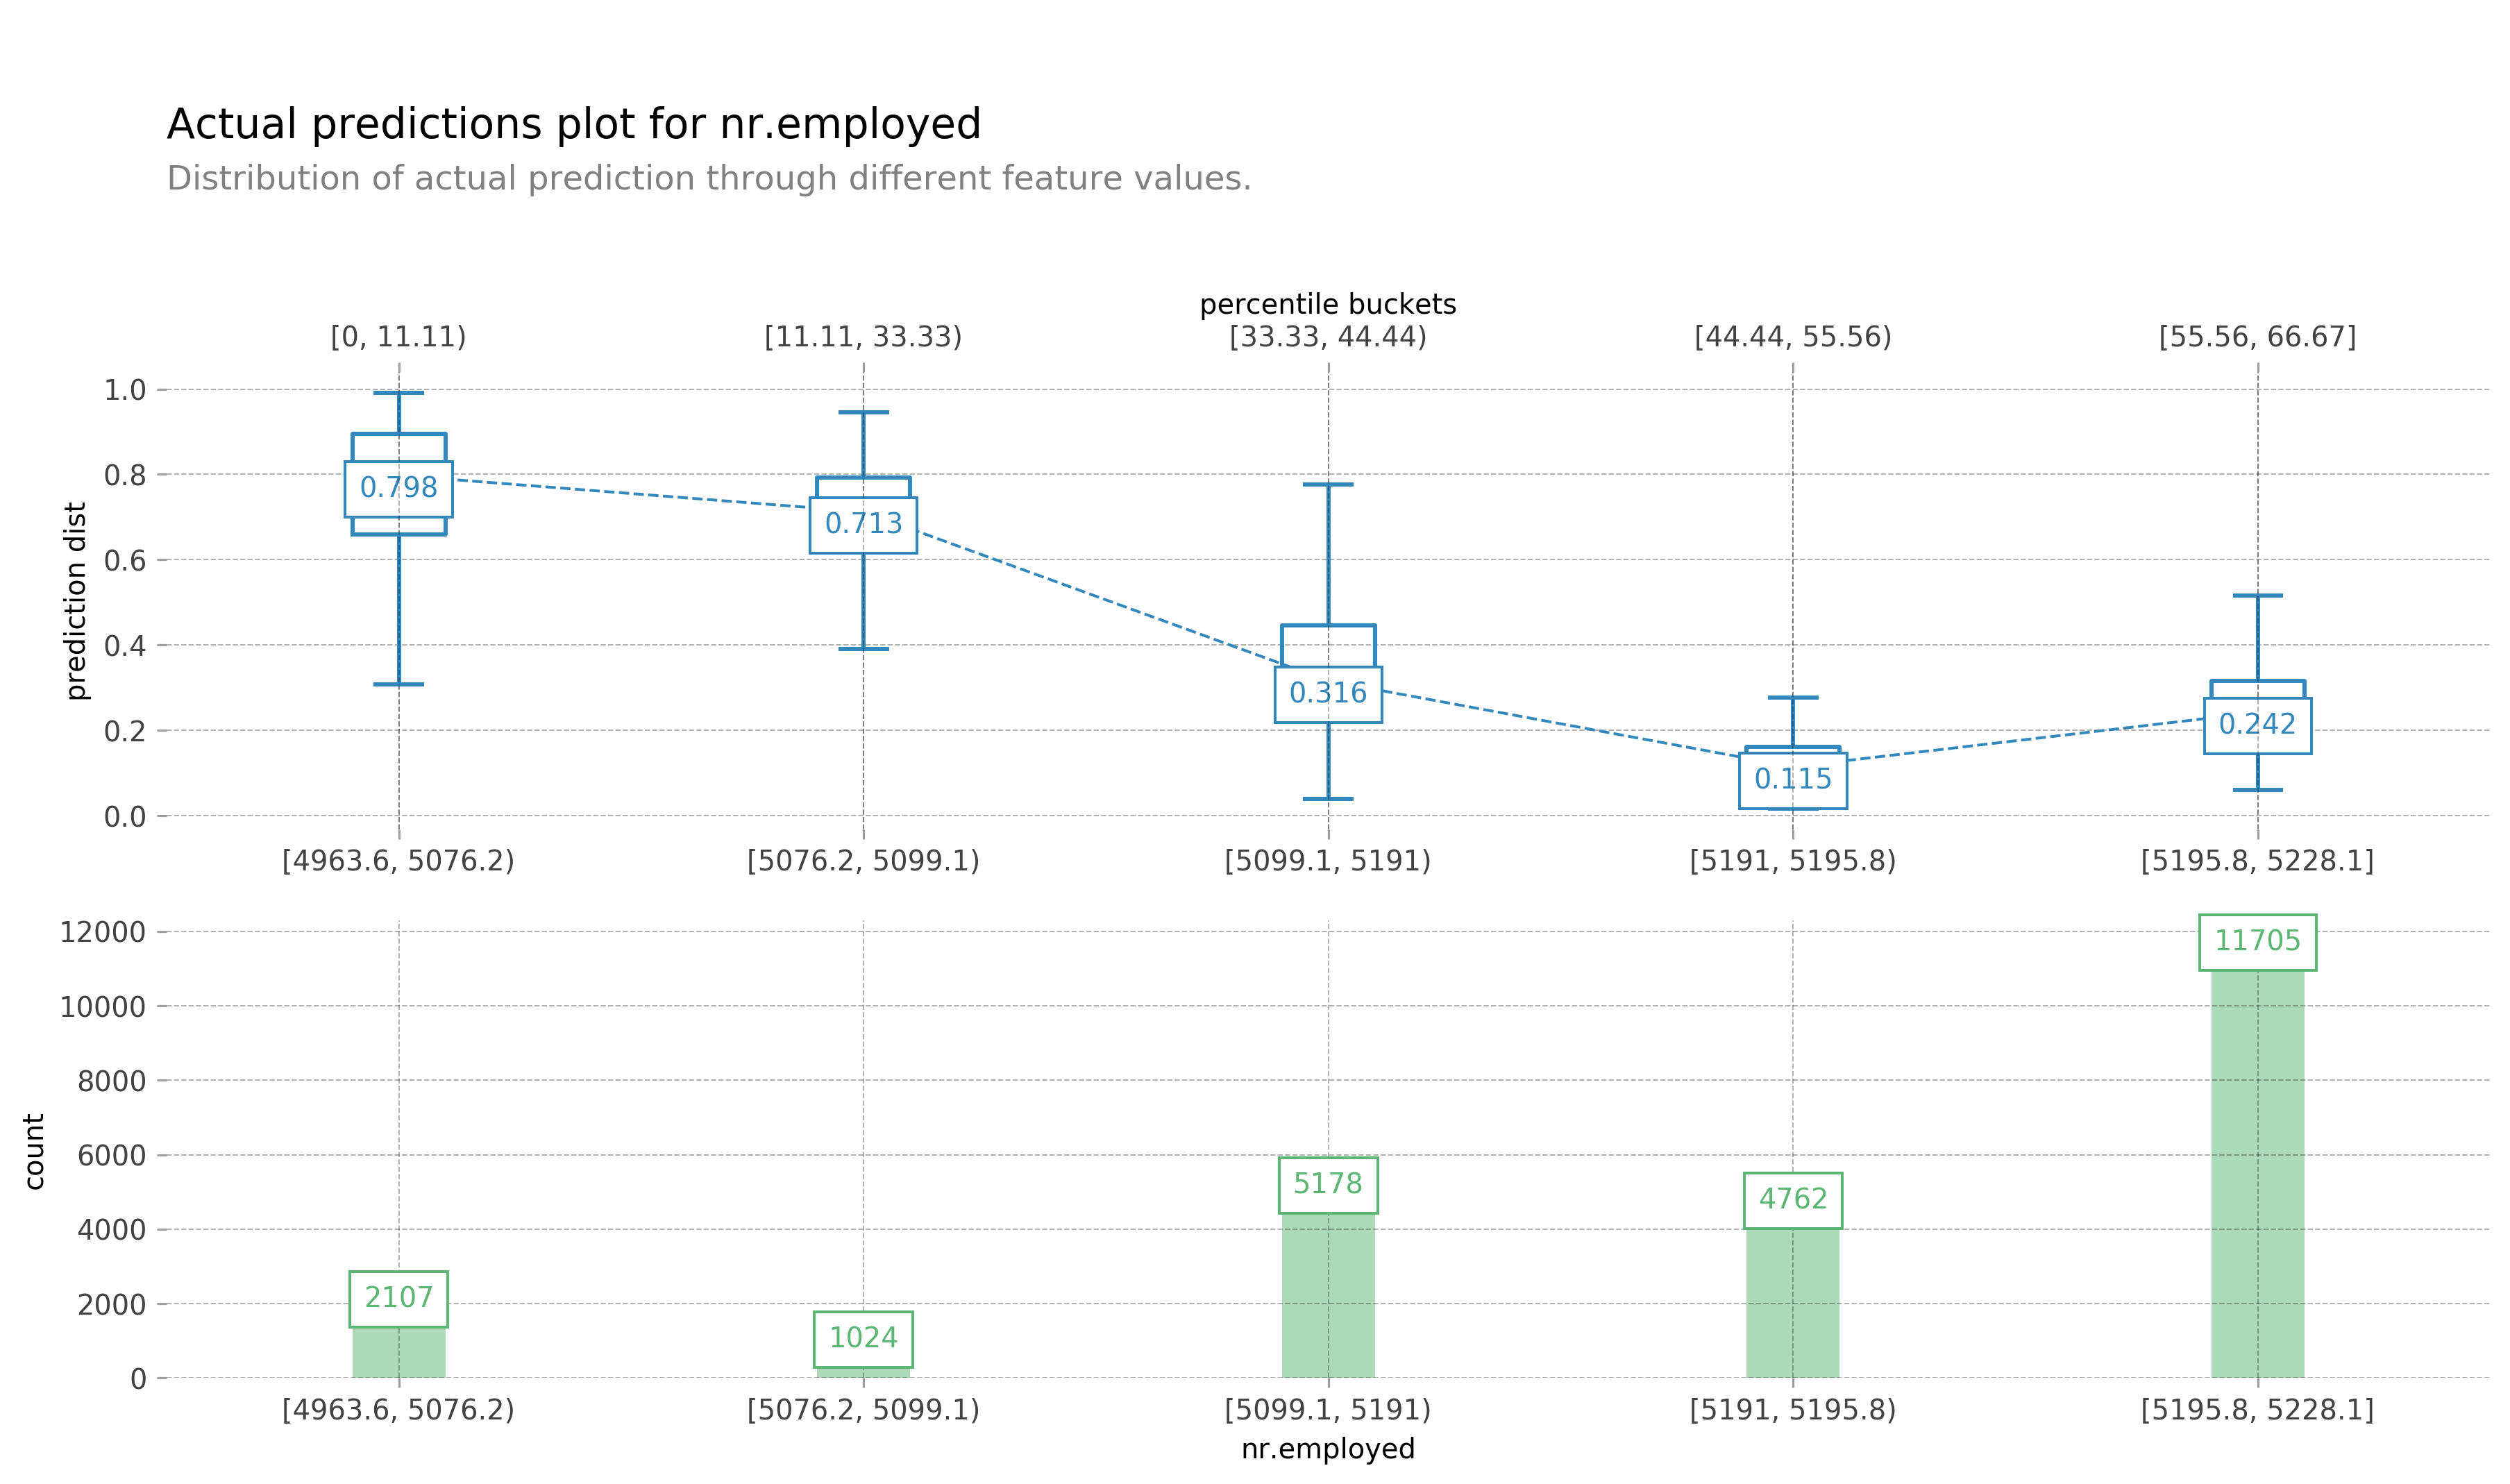

In [ ]:

from pdpbox import pdp, get_dataset
model_rf = pipe.named_steps['randomforestclassifier']
X_train_encoded = pipe.named_steps['targetencoder'].fit_transform(X_train,y_train)

fig, axes, summary_df = info_plots.actual_plot(
    model =model_rf, X = X_train_encoded, feature='nr.employed', feature_name='nr.employed',
    show_percentile=True
)

직원 수가 낮을때 가입 확률이 더 높다고 예측.

### 금리와 마케팅 결과

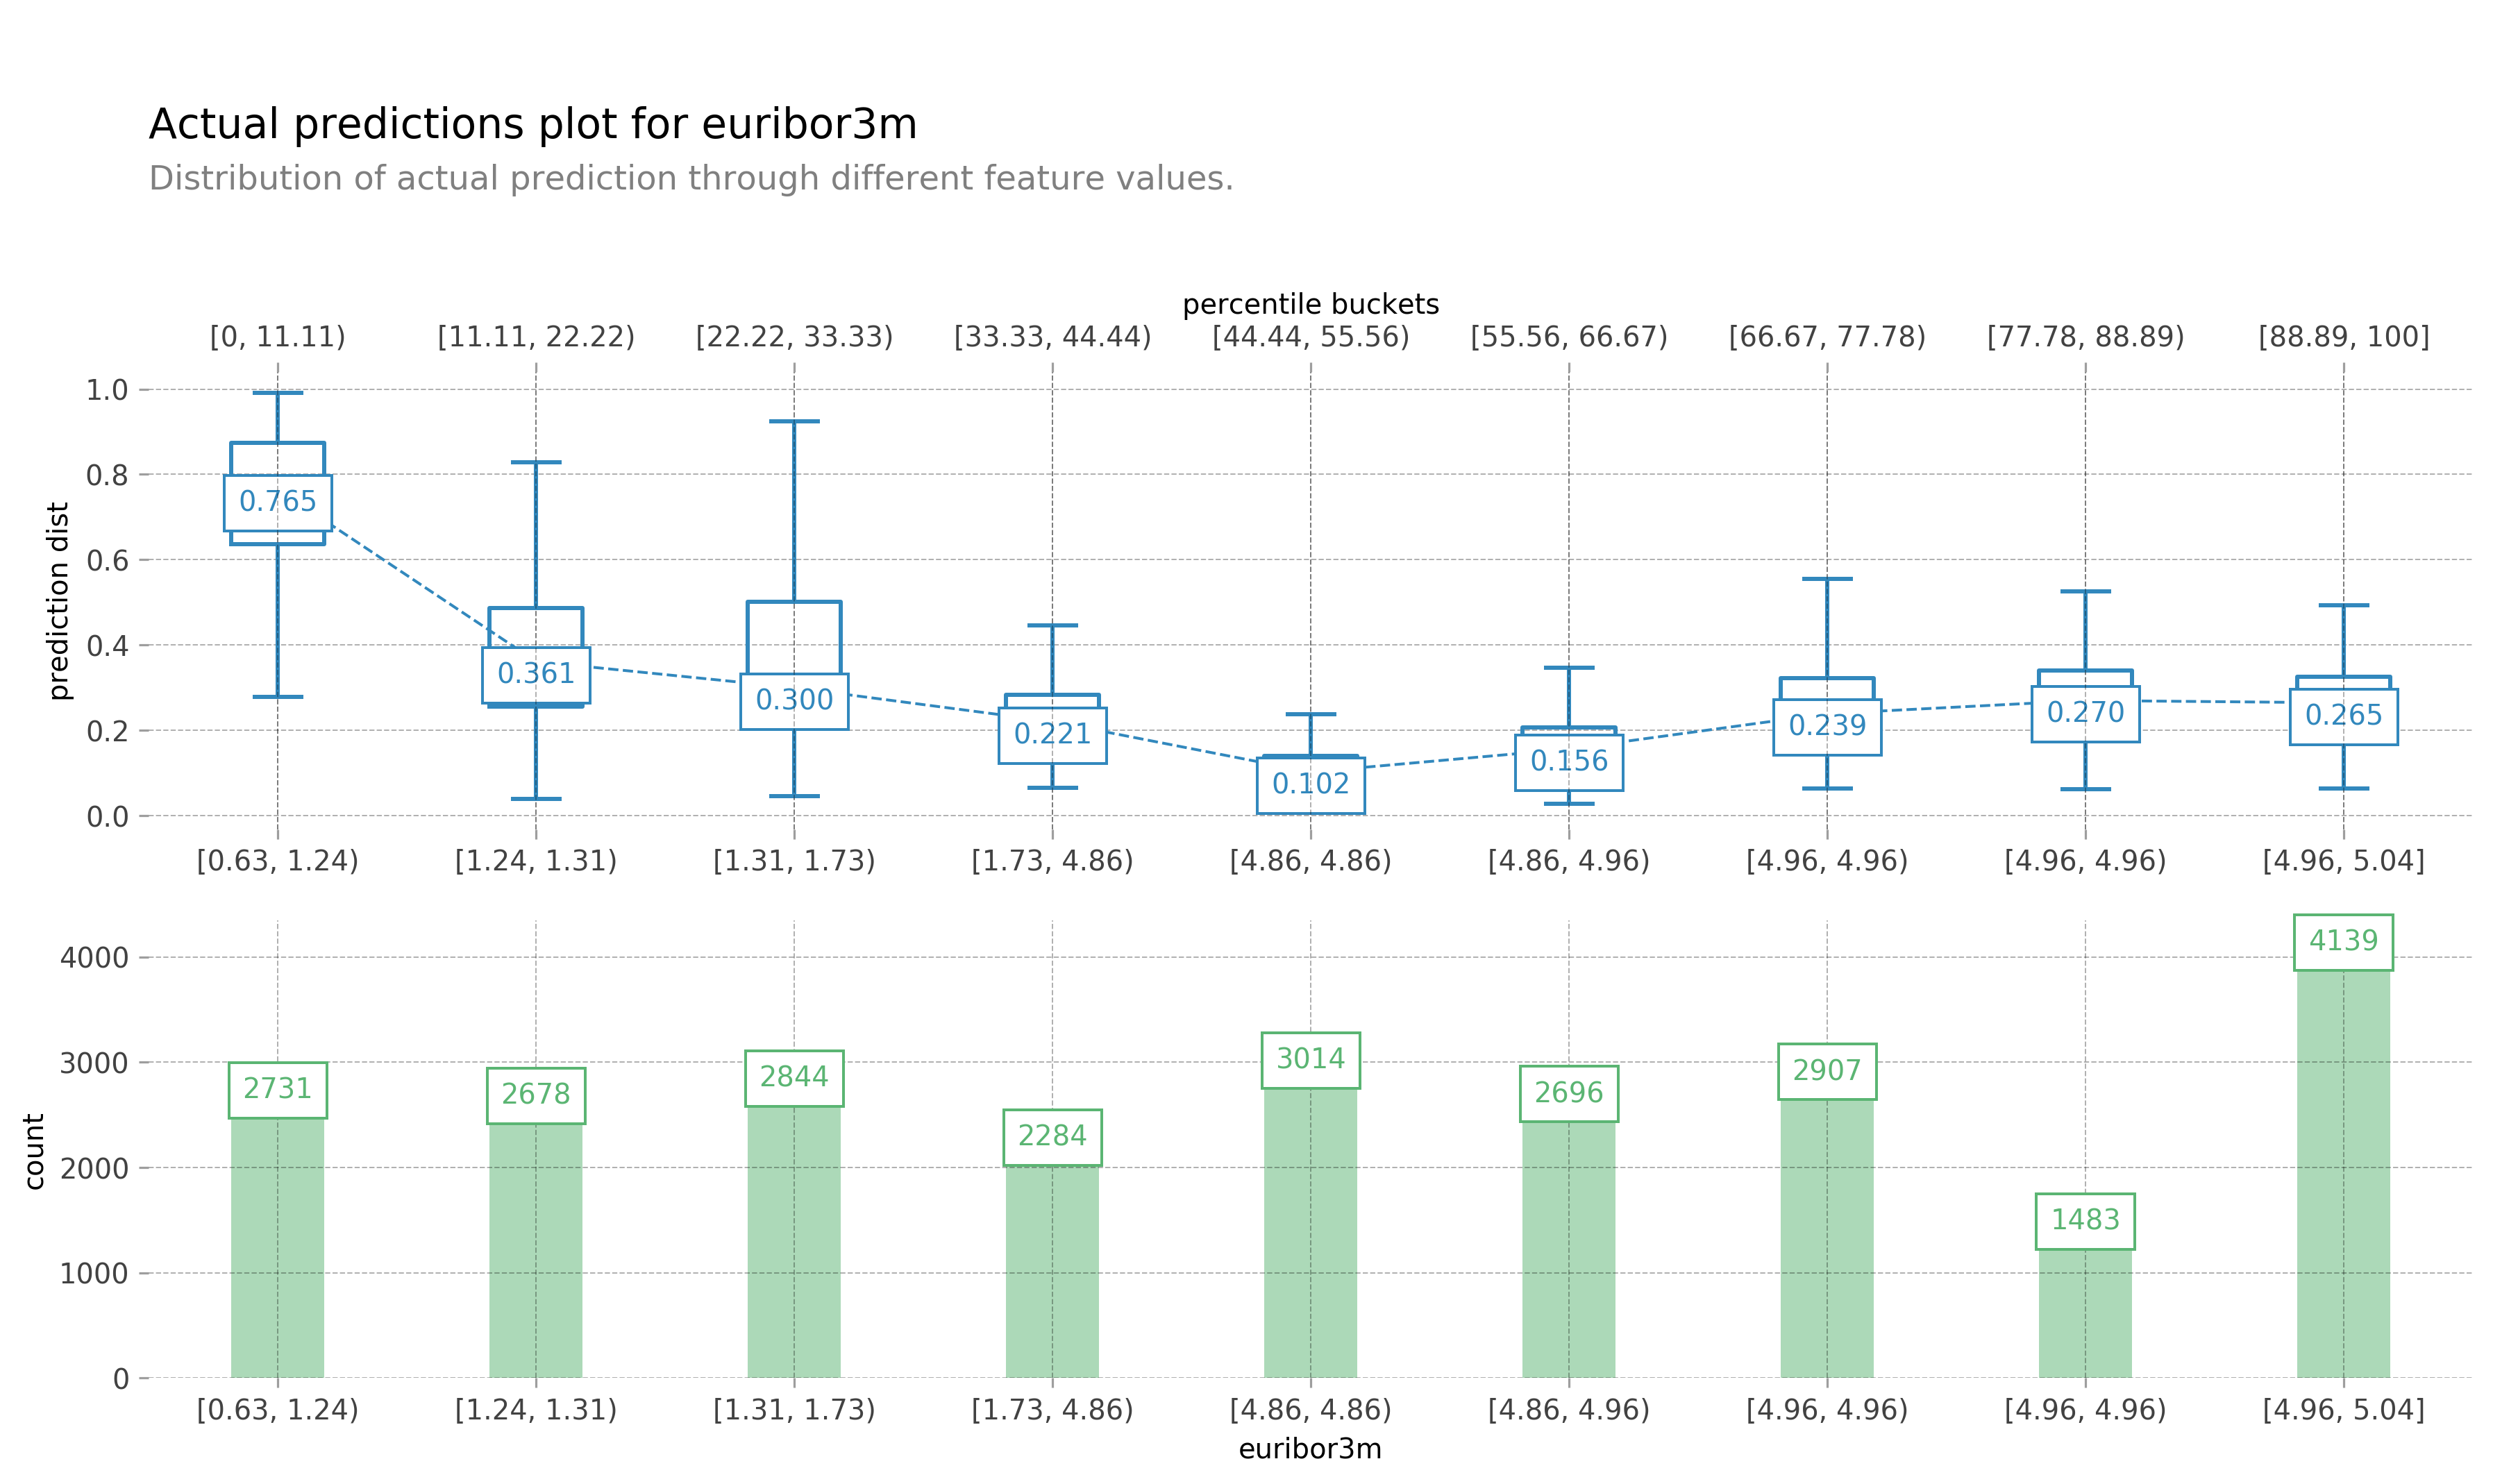

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model =model_rf, X = X_train_encoded, feature='euribor3m', feature_name='euribor3m',
    show_percentile = True
)

금리가 낮을때 가입 확률이 더 높다고 예측.

In [ ]:
import shap

row = X_test.iloc[:100]

explainer = shap.TreeExplainer(model_rf)
row_transform = encoder.transform(row)
shap_values = explainer.shap_values(row_transform)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value[1],
    shap_values = shap_values[1],
    features=row,
    link = 'logit'
)

### 금리 & 직원수와 마케팅 결과



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


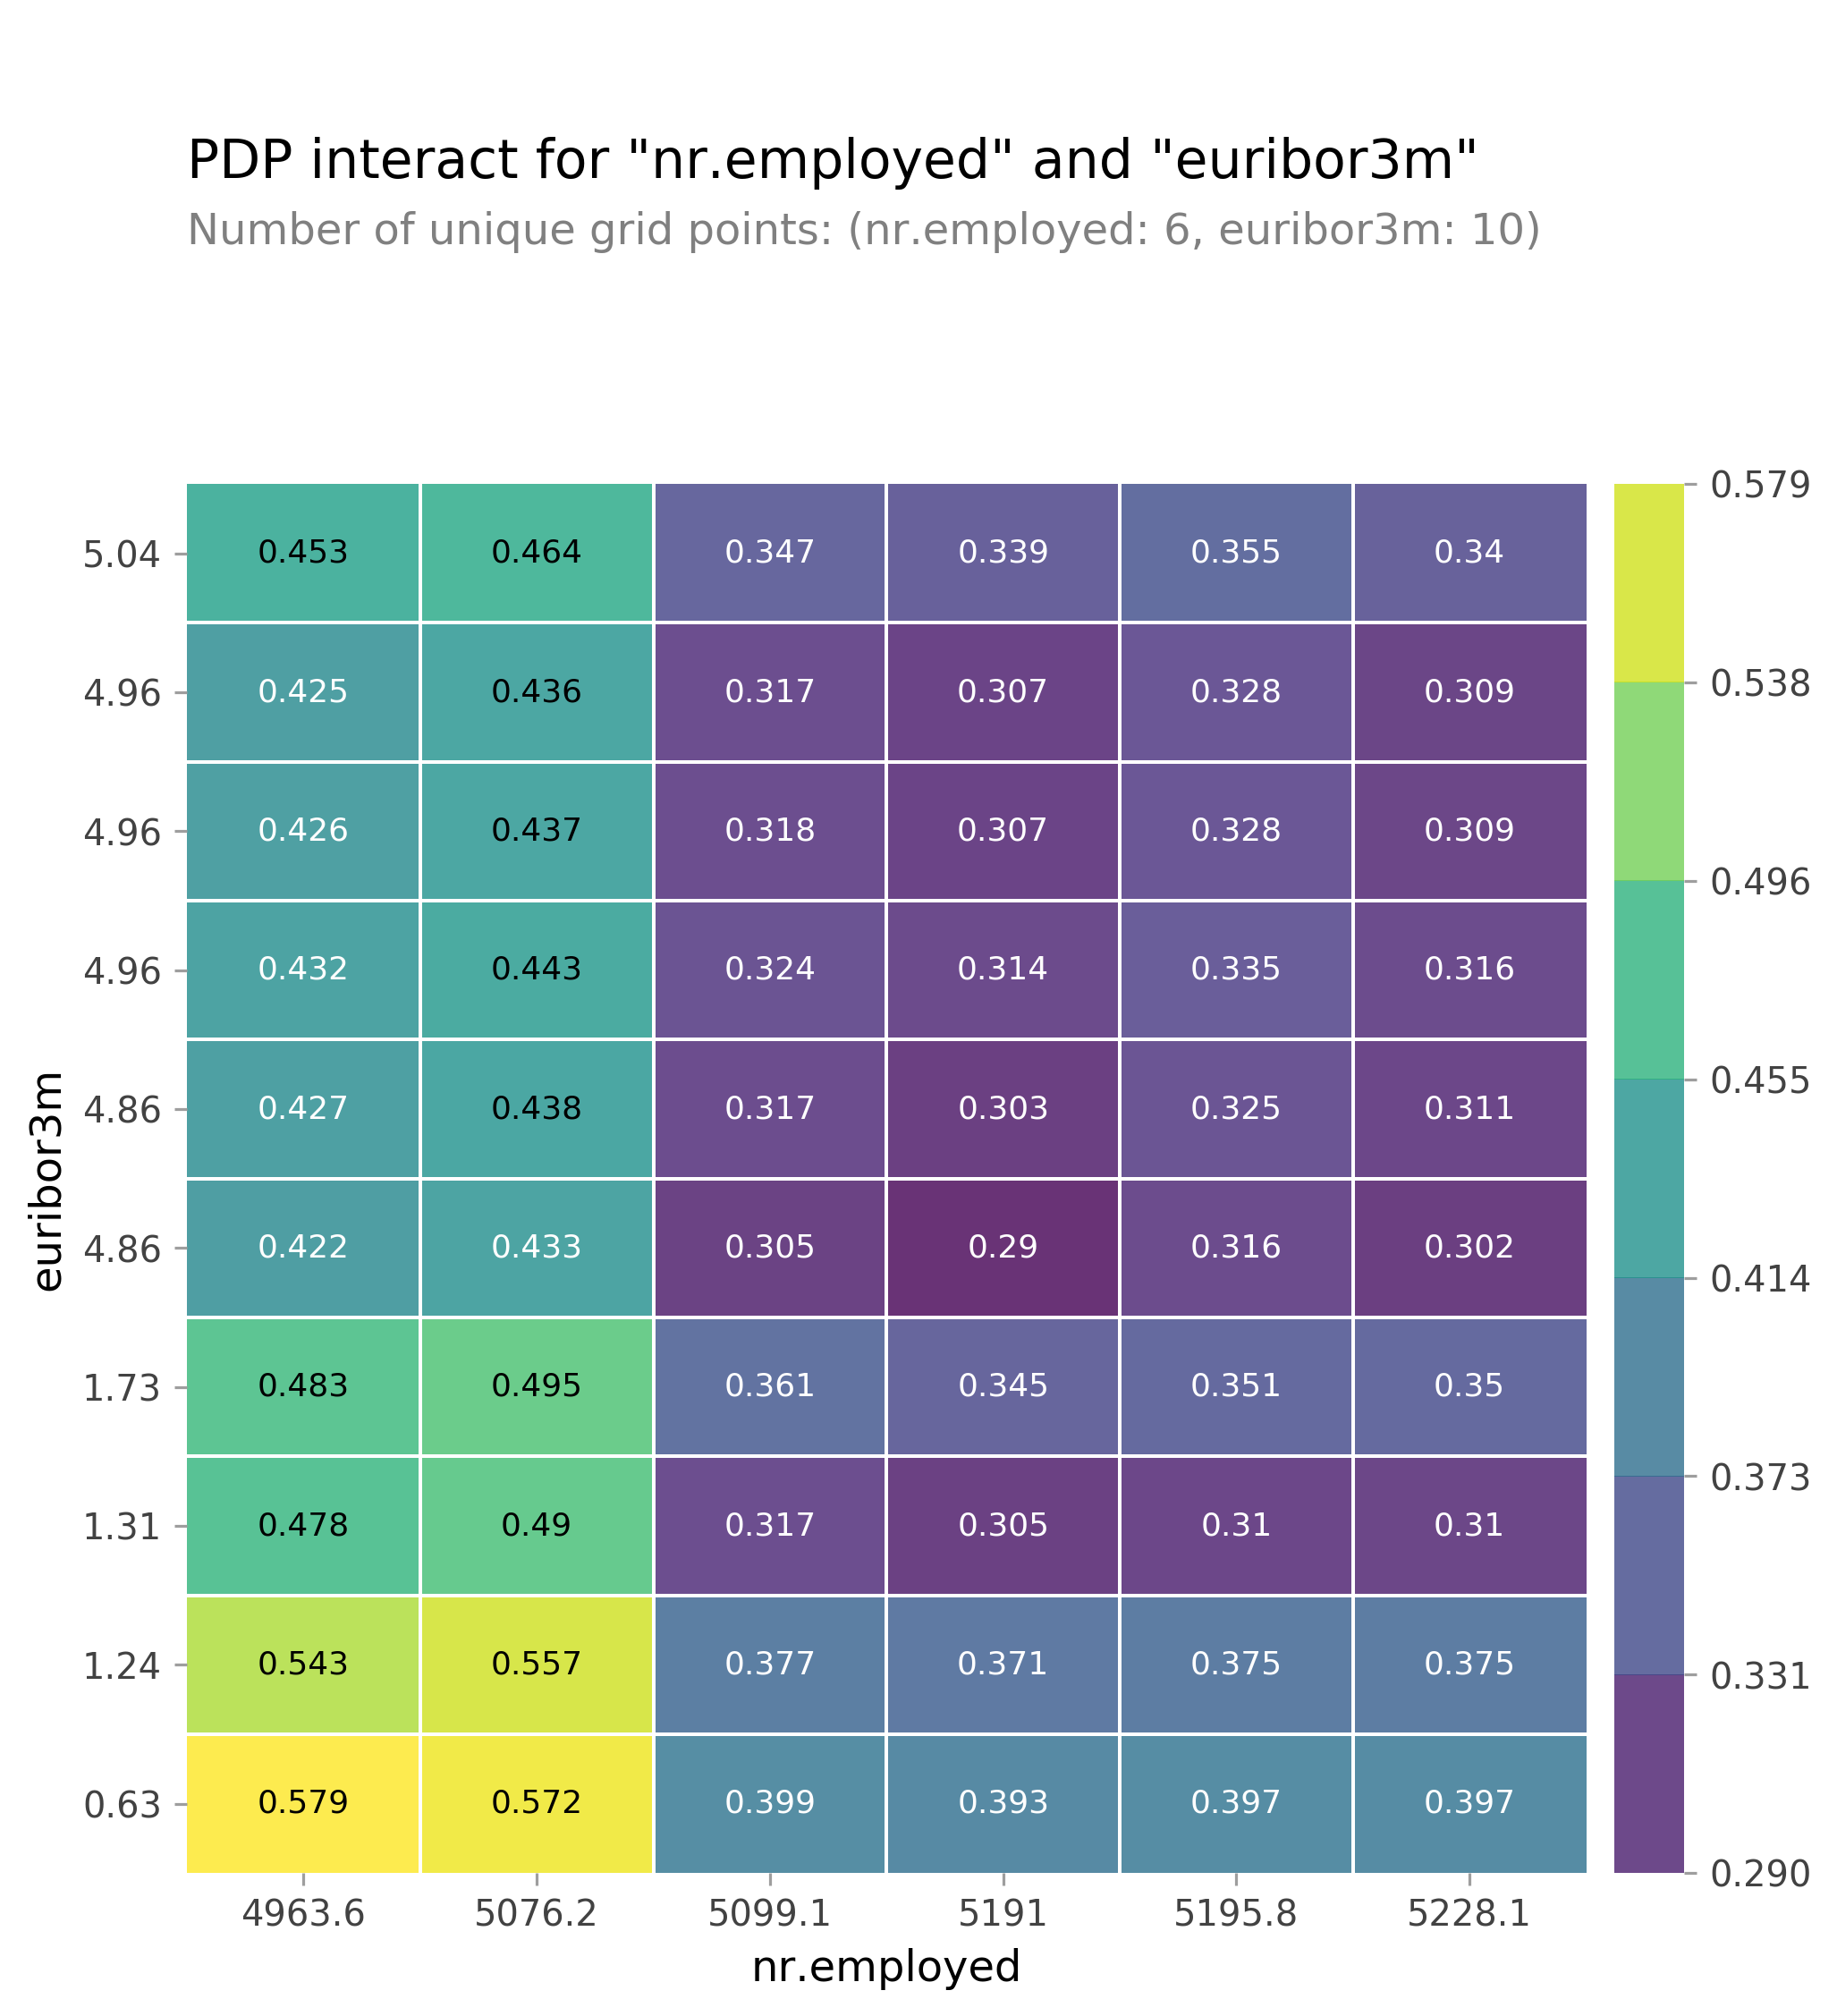

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['nr.employed', 'euribor3m']

interaction = pdp_interact(
    model = model_rf,
    dataset = X_train_encoded,
    model_features = X_train_encoded.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

금리가 낮고 직원수가 적을 수록 마케팅이 성공할 확률이 높다.

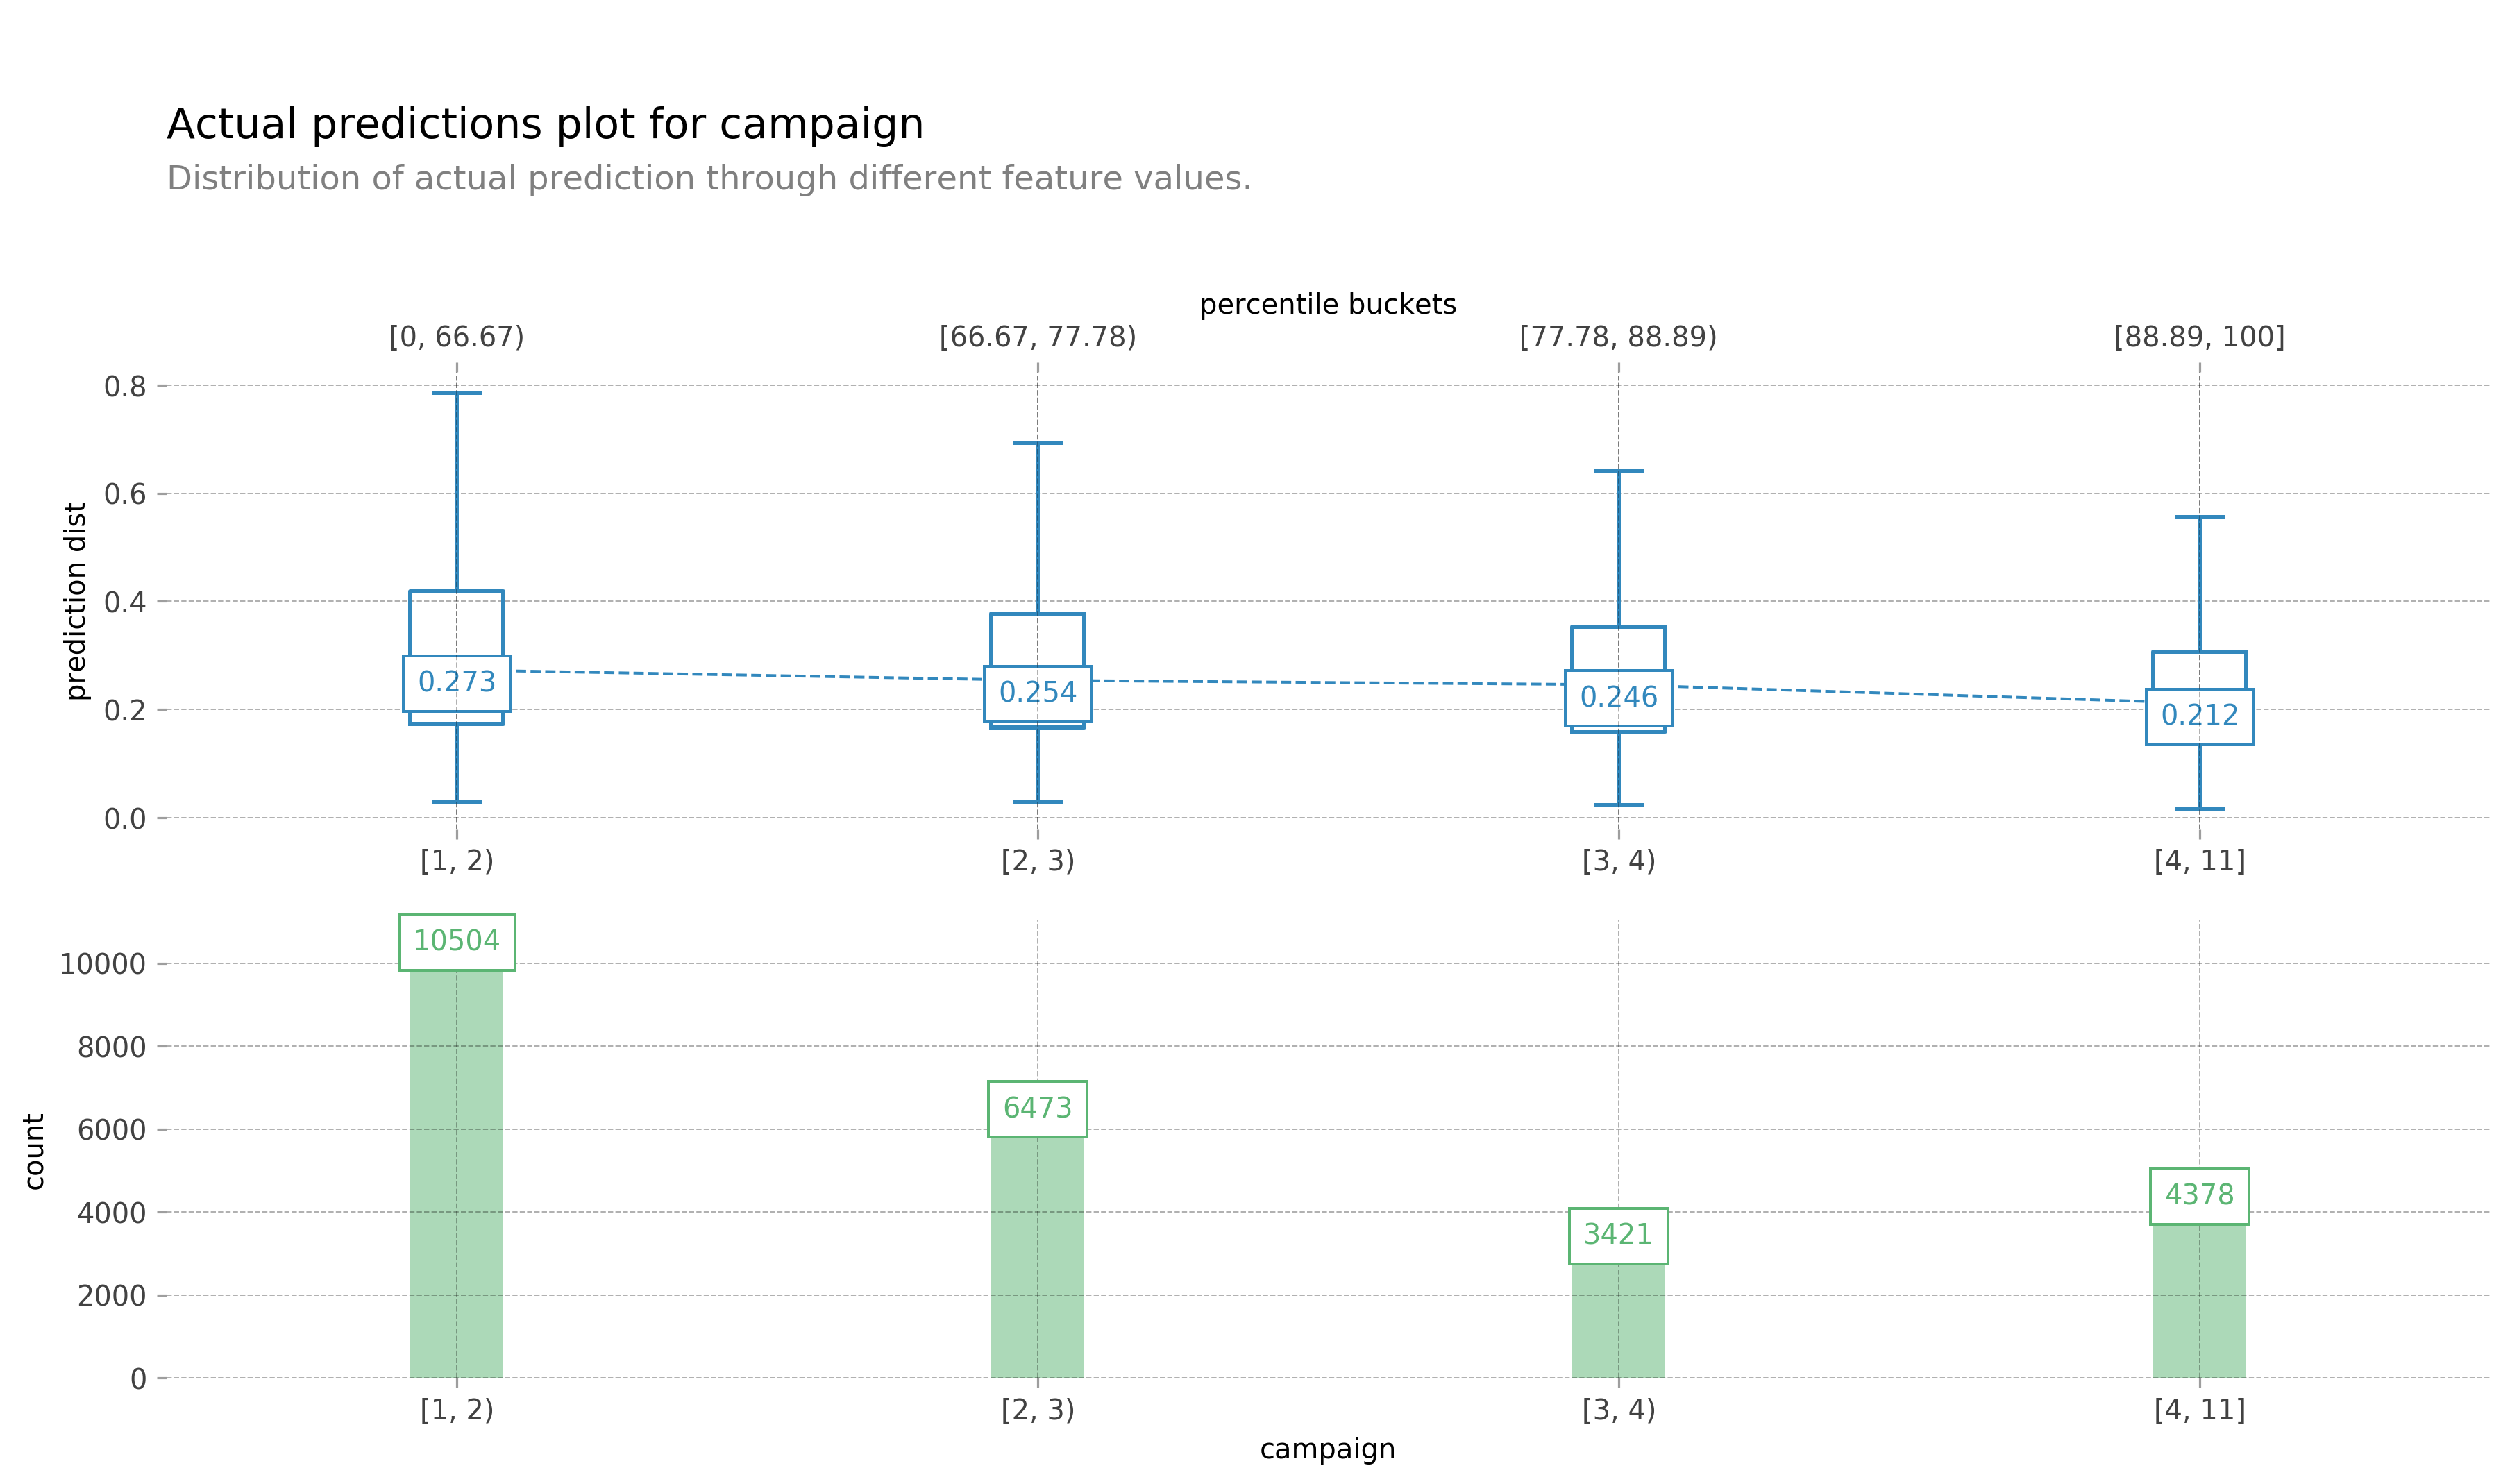

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model =model_rf, X = X_train_encoded, feature='campaign', feature_name='campaign',
    show_percentile = True
)

고객 접촉 횟수와 가입 확률은 크게 관련이 없어보인다.

## 결론

- 앞서 세운 가설과 모델을 해석해본 결과를 비교해보면, 경기지표가 마케팅 결과에 영향을 끼쳤다고 볼 수 있고 그 중 특히 금리가 큰 영향을 끼쳤다고 볼 수 있다. 

- 하지만 마케팅 기간 동안 고객에게 많이 접촉할 경우 반감이 생겨 마케팅 결과에 악영향을 끼칠 것이라는 가설은 성립한다고 보기 힘들었다.

- 결과적으로 금리가 낮은 시기에 너무 많은 직원수 말고 적정한 직원수를 바탕으로 마케팅을 실시한다면 보다 효율적인 마케팅을 할 수 있다는 결론을 내릴 수 있었다.

## 한계점

- 데이터가 오래되었다는 점.
- 타겟의 불균형이 심한 데이터였는데, 이러한 불균형 문제를 완벽히 해결하지 못해 모델의 성능이 만족할 만큼 나오지 못했다. 
- 이로 인해 모델 결과 해석의 신뢰도가 떨어진다는 점이 한계라고 생각.